# ⚛️ H₃⁺ Noiseless VQE — UCC-S vs UCC-D vs UCCSD

This notebook compares three chemistry-inspired VQE ansatzes for **H₃⁺**
using only the production VQE entrypoint:

```python
from vqe.core import run_vqe
```

Common settings:
- Noiseless simulation (`default.qubit`)
- Optimizer: Adam
- Fixed step budget and stepsize

Ansätze compared:
- **UCC-S**  (singles)
- **UCC-D**  (doubles)
- **UCCSD**  (singles + doubles)

Outputs:
- Convergence curves
- Final energies
- Final statevector (significant components)

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt

from vqe.core import run_vqe
from common.molecules import get_molecule_config
from common.molecule_viz import plot_molecule
from common.plotting import save_plot, build_filename

In [2]:
seed = 0

steps = 50
stepsize = 0.2
optimizer = "Adam"

molecule = "H3+"
ansatzes = ["UCC-S", "UCC-D", "UCCSD"]

## 🧬 Geometry (registry) visualization

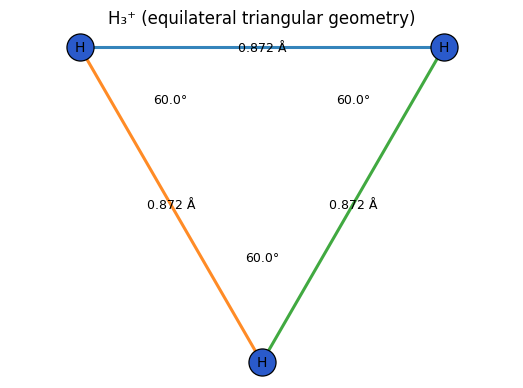

In [3]:
mol = get_molecule_config(molecule)

plot_molecule(
    mol["symbols"],
    mol["coordinates"],
    title="H₃⁺ (equilateral triangular geometry)",
    bonds=[(0, 1), (1, 2), (2, 0)],
    angles=[(0, 1, 2), (1, 2, 0), (2, 0, 1)],
    show_bond_lengths=True,
    show_atom_indices=False,
)
plt.show()

## 🚀 Run VQE for UCC-S / UCC-D / UCCSD

In [4]:
results = {}

for ansatz in ansatzes:
    print(f"\n▶ Running VQE: molecule={molecule}, ansatz={ansatz}")
    rec = run_vqe(
        molecule=molecule,
        ansatz_name=ansatz,
        optimizer_name=optimizer,
        steps=int(steps),
        stepsize=float(stepsize),
        noisy=False,
        plot=False,
        seed=int(seed),
        force=False,
        mapping="jordan_wigner",
    )
    results[ansatz] = rec

num_qubits = int(next(iter(results.values()))["num_qubits"])
print(f"\nSystem qubits: {num_qubits}")


▶ Running VQE: molecule=H3+, ansatz=UCC-S

▶ Running VQE: molecule=H3+, ansatz=UCC-D

▶ Running VQE: molecule=H3+, ansatz=UCCSD

System qubits: 6


## 📉 Convergence comparison

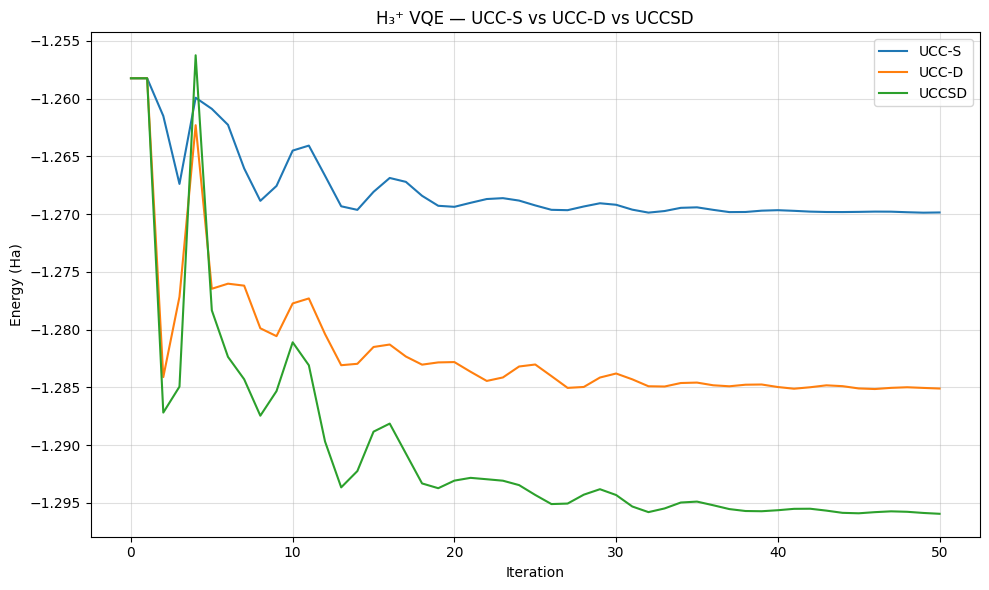

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/ansatz_comp_Adam_s0.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/ansatz_comp_Adam_s0.png'

In [5]:
plt.figure(figsize=(10, 6))
for ansatz in ansatzes:
    plt.plot(results[ansatz]["energies"], label=ansatz)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ VQE — UCC-S vs UCC-D vs UCCSD")
plt.grid(True, alpha=0.4)
plt.legend()
plt.tight_layout()

fname = build_filename(
    topic="ansatz_comp",
    optimizer=optimizer,
    multi_seed=False,
    seed=int(seed),
)
save_plot(fname, kind="vqe", molecule=molecule, show=True)

## 📊 Final energies summary

In [6]:
print("\nFinal energies (noisy runs):")
for ans in ansatzes:
    print(f"  {ans:6s} → E = {float(results[ans]['energy']):.8f} Ha")


Final energies (noisy runs):
  UCC-S  → E = -1.26985471 Ha
  UCC-D  → E = -1.28510271 Ha
  UCCSD  → E = -1.29595113 Ha


## 🔍 Final statevector (significant components)

In [7]:
def reconstruct_state(rec: dict) -> np.ndarray:
    psi_r = np.array(rec["final_state_real"], dtype=float)
    psi_i = np.array(rec["final_state_imag"], dtype=float)
    return psi_r + 1j * psi_i

threshold = 1e-2

for ansatz in ansatzes:
    print("\n" + "-" * 70)
    print(f"Final state decomposition: {ansatz}")

    psi = reconstruct_state(results[ansatz])
    nz_idx = np.where(np.abs(psi) > threshold)[0]

    terms = []
    for idx in nz_idx:
        amp = psi[idx]
        bit = f"|{idx:0{num_qubits}b}⟩"
        if abs(amp.imag) < 1e-6:
            term = f"{amp.real:.4f}{bit}"
        else:
            term = f"({amp.real:.4f}{amp.imag:+.4f}j){bit}"
        terms.append(term)

    if terms:
        print(" |ψ⟩ ≈ " + " + ".join(terms))
    else:
        print(f" (no components with |cᵢ| > {threshold:g})")


----------------------------------------------------------------------
Final state decomposition: UCC-S
 |ψ⟩ ≈ 0.1355|101001⟩ + 0.9907|111000⟩

----------------------------------------------------------------------
Final state decomposition: UCC-D
 |ψ⟩ ≈ -0.0985|001011⟩ + -0.1333|100110⟩ + 0.9861|111000⟩

----------------------------------------------------------------------
Final state decomposition: UCCSD
 |ψ⟩ ≈ -0.1056|001011⟩ + 0.0119|001110⟩ + 0.0229|100011⟩ + -0.1207|100110⟩ + 0.1287|101001⟩ + -0.0224|101100⟩ + -0.1401|110010⟩ + 0.9679|111000⟩
